# Istanbul Stock Exchange Data Experiment 
Semi-synthetic dataset experiment

<strong>Note</strong>: This notebook yields the most stable results out of any of the notebooks submitted.

In [1]:
import sys 
sys.path.append('..')
import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from delphi.oracle import Left 
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset

# Import Istanbul Stock Exchange Dataset into Notebook
You need to download the [ISTANBUL STOCK EXCHANGE](https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE) dataset from the UCI dataset repository.

In [2]:
ISTANBUL_DATASET_PATH = '<Give path to xcel file here>'
ISTANBUL_DATASET_PATH = '/home/pstefanou/data_akbilgic.xlsx'
ist_df = pd.read_excel(ISTANBUL_DATASET_PATH, engine='openpyxl')
ist_df.head()

/home/pstefanou/env/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


# Create Correlation Matrix
Create a correlation matrix to see which indices' performances are closely correlated with one another.

(              ISE     ISE.1        SP       DAX      FTSE    NIKKEI   BOVESPA  \
 ISE      1.000000  0.942897  0.439489  0.602081  0.622948  0.260052  0.432898   
 ISE.1    0.942897  1.000000  0.449561  0.629218  0.648740  0.393225  0.446889   
 SP       0.439489  0.449561  1.000000  0.685843  0.657673  0.131250  0.722069   
 DAX      0.602081  0.629218  0.685843  1.000000  0.867369  0.258538  0.585791   
 FTSE     0.622948  0.648740  0.657673  0.867369  1.000000  0.255236  0.596287   
 NIKKEI   0.260052  0.393225  0.131250  0.258538  0.255236  1.000000  0.172752   
 BOVESPA  0.432898  0.446889  0.722069  0.585791  0.596287  0.172752  1.000000   
 EU       0.655519  0.690761  0.687550  0.936393  0.948963  0.283750  0.621704   
 EM       0.600295  0.701954  0.528243  0.665162  0.687543  0.547288  0.688074   
 
                EU        EM  
 ISE      0.655519  0.600295  
 ISE.1    0.690761  0.701954  
 SP       0.687550  0.528243  
 DAX      0.936393  0.665162  
 FTSE     0.948963  0.6

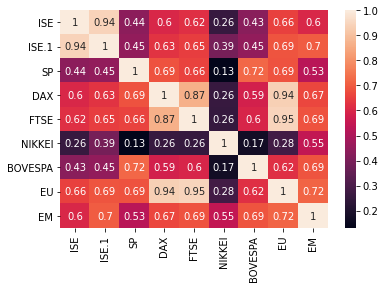

In [3]:
indices = ist_df.drop(['date'], axis=1)
corr_matrix = indices.corr()
corr_matrix, sns.heatmap(corr_matrix, annot=True)

# Data Preprocessing
Select the performance results for the EM and EU indices. Since, the performance results are expressed in decimals (because they are percentages) and are extremely small, we standardize the data, so that are gradients aren't negatively influenced by the magnitude of the performance rates.

In [4]:
X = ch.from_numpy(np.expand_dims(indices['EM'], 1))
y = ch.from_numpy(np.expand_dims(indices['EU'], 1))

# standardize data, so that the values are not all small floating points
X_scaler, y_scaler = preprocessing.StandardScaler().fit(X), preprocessing.StandardScaler().fit(y)
X, y = ch.from_numpy(X_scaler.transform(X)).float(), ch.from_numpy(y_scaler.transform(y))

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [12]:
# truncate dataset
c = 1.0
phi = Left(Tensor([c]))
trunc_indices = phi(y).nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[trunc_indices], y[trunc_indices]

# experiment hyperparameters
args = Parameters({ 
    'alpha': Tensor([y_trunc.shape[0]/y.shape[0]]), 
    'phi': phi, 
    'epochs': 100,
    'num_workers': 2, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 2.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'unknown': True,
})

# Create Store for Experiment Results

In [13]:
STORE_PATH = '<Give Path to Store Data Here>'
STORE_PATH = '/home/pstefanou/test__'
STORE_TABLE_NAME = '<Give Store Table Name here>'
STORE_TABLE_NAME = 'test'

# create store
s = Store(STORE_PATH)
s.add_table(STORE_TABLE_NAME, { 
    'c': float, 
    'pred_var_mse': float, 
    'pred_param_mse': float, 
    'emp_var_mse': float, 
    'emp_param_mse': float,
})

Logging in: /home/pstefanou/test__/7f6b5d63-c4a0-4bf2-a75f-ce4d043986b0


# Run Procedure

In [14]:
# groun_truth parameters
lin_reg = LinearRegression() 
lin_reg.fit(X, y)
real_params = np.array([lin_reg.coef_, lin_reg.intercept_])
real_var = np.var(lin_reg.predict(X) - y.numpy(), 0)

# smallest number of surviving samples when varying truncation parameter C
num_samples = 199

C = [-1, -.75, -.5, -.25, 0, .25]
for i in range(20):
    for c in C: 
        # truncate
        phi = Left(Tensor([c]))
        trunc_indices = phi(y).nonzero(as_tuple=False).flatten()
        x_trunc, y_trunc = X[trunc_indices], y[trunc_indices]
        # add survival probability to hyperparameters
        alpha = x_trunc.shape[0]/X.shape[0]
        
        """
        If there are more than 199 samples within the truncation set, then select the first 
        199 samples from a random permutation of the survival set.
        """
        indices = ch.randperm(x_trunc.size(0))[:num_samples]
        x_trunc, y_trunc = x_trunc[indices], y_trunc[indices]

        # intialize datset
        dataset = TruncatedRegressionDataset(x_trunc, y_trunc.float(), bias=args.bias, unknown=args.unknown)
        S = DataLoader(dataset, batch_size=args.batch_size)

        trunc_reg = truncated_regression(phi=phi, alpha=alpha, unknown=args.unknown, lr=args.lr, var_lr=args.var_lr, num_samples=args.num_samples, epochs=args.epochs)
        results = trunc_reg.fit(S)

        with ch.no_grad():
            delphi_params = ch.cat([results.v*results.lambda_.inverse(), results.bias*results.lambda_.inverse()])
            delphi_var = results.lambda_.inverse()

            emp_params = ch.cat([dataset.w, dataset.w0.unsqueeze(0)])
            emp_var = dataset.lambda_.inverse()

            s[STORE_TABLE_NAME].append_row({ 
                'c': c, 
                'pred_param_mse': mean_squared_error(delphi_params, real_params), 
                'pred_var_mse': mean_squared_error(real_var, delphi_var),
                'emp_param_mse': mean_squared_error(emp_params, real_params), 
                'emp_var_mse': mean_squared_error(emp_var, real_var)
            })
            
# close current store
s.close()

Epoch:1 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.10it/s]
Epoch:2 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.23it/s]
Epoch:3 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.96it/s]
Epoch:4 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.35it/s]
Epoch:5 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.81it/s]
Epoch:6 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.96it/s]
Epoch:7 | Loss 0.1710 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.63it/s]
Epoch:8 | Loss 0.1710 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.15it/s]
Epoch:9 | Loss 0.1710 | Train1 0.427 | Train5 -1

Epoch:69 | Loss 0.1745 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.98it/s]
Epoch:70 | Loss 0.1745 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.49it/s]
Epoch:71 | Loss 0.1746 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.01it/s]
Epoch:72 | Loss 0.1746 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 51.38it/s]
Epoch:73 | Loss 0.1746 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.24it/s]
Epoch:74 | Loss 0.1746 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.03it/s]
Epoch:75 | Loss 0.1747 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.03it/s]
Epoch:76 | Loss 0.1747 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.91it/s]
Epoch:77 | Loss 0.1748 | Train1 0.462 | 

Epoch:37 | Loss 0.1940 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.07it/s]
Epoch:38 | Loss 0.1944 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.59it/s]
Epoch:39 | Loss 0.1946 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.12it/s]
Epoch:40 | Loss 0.1947 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 54.57it/s]
Epoch:41 | Loss 0.1951 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.04it/s]
Epoch:42 | Loss 0.1946 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.75it/s]
Epoch:43 | Loss 0.1949 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s]
Epoch:44 | Loss 0.1952 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.94it/s]
Epoch:45 | Loss 0.1955 | Train1 0.497 | 

Epoch:5 | Loss 0.1667 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.97it/s]
Epoch:6 | Loss 0.1667 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.77it/s]
Epoch:7 | Loss 0.1667 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.04it/s]
Epoch:8 | Loss 0.1667 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s]
Epoch:9 | Loss 0.1667 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.94it/s]
Epoch:10 | Loss 0.1667 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.30it/s]
Epoch:11 | Loss 0.1668 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:12 | Loss 0.1668 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s]
Epoch:13 | Loss 0.1668 | Train1 0.432 | Train

Epoch:73 | Loss 0.1795 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]
Epoch:74 | Loss 0.1795 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]
Epoch:75 | Loss 0.1796 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.00it/s]
Epoch:76 | Loss 0.1797 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:77 | Loss 0.1798 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.32it/s]
Epoch:78 | Loss 0.1798 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.35it/s]
Epoch:79 | Loss 0.1799 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.02it/s]
Epoch:80 | Loss 0.1799 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:81 | Loss 0.1800 | Train1 0.523 | 

Epoch:41 | Loss 0.1550 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.65it/s]
Epoch:42 | Loss 0.1554 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:43 | Loss 0.1558 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.17it/s]
Epoch:44 | Loss 0.1558 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.35it/s]
Epoch:45 | Loss 0.1561 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s]
Epoch:46 | Loss 0.1561 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]
Epoch:47 | Loss 0.1561 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]
Epoch:48 | Loss 0.1562 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.60it/s]
Epoch:49 | Loss 0.1565 | Train1 0.472 | 

Epoch:9 | Loss 0.1641 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
Epoch:10 | Loss 0.1642 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.17it/s]
Epoch:11 | Loss 0.1642 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.82it/s]
Epoch:12 | Loss 0.1643 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.88it/s]
Epoch:13 | Loss 0.1644 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.52it/s]
Epoch:14 | Loss 0.1645 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.93it/s]
Epoch:15 | Loss 0.1645 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:16 | Loss 0.1646 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.05it/s]
Epoch:17 | Loss 0.1649 | Train1 0.467 | T

Epoch:77 | Loss 0.1822 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:78 | Loss 0.1823 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]
Epoch:79 | Loss 0.1824 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]
Epoch:80 | Loss 0.1825 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.34it/s]
Epoch:81 | Loss 0.1827 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:82 | Loss 0.1828 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.84it/s]
Epoch:83 | Loss 0.1828 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.29it/s]
Epoch:84 | Loss 0.1828 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.17it/s]
Epoch:85 | Loss 0.1829 | Train1 0.482 | 

Epoch:45 | Loss 0.1564 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.10it/s]
Epoch:46 | Loss 0.1563 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]
Epoch:47 | Loss 0.1562 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]
Epoch:48 | Loss 0.1566 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
Epoch:49 | Loss 0.1569 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.65it/s]
Epoch:50 | Loss 0.1572 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]
Epoch:51 | Loss 0.1576 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]
Epoch:52 | Loss 0.1577 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s]
Epoch:53 | Loss 0.1582 | Train1 0.613 | 

Epoch:13 | Loss 0.1573 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s]
Epoch:14 | Loss 0.1573 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.30it/s]
Epoch:15 | Loss 0.1572 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:16 | Loss 0.1573 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]
Epoch:17 | Loss 0.1573 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]
Epoch:18 | Loss 0.1574 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.17it/s]
Epoch:19 | Loss 0.1574 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.47it/s]
Epoch:20 | Loss 0.1574 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.74it/s]
Epoch:21 | Loss 0.1574 | Train1 0.467 | 

Epoch:81 | Loss 0.1603 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:82 | Loss 0.1603 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.89it/s]
Epoch:83 | Loss 0.1603 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.88it/s]
Epoch:84 | Loss 0.1603 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]
Epoch:85 | Loss 0.1603 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.62it/s]
Epoch:86 | Loss 0.1603 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]
Epoch:87 | Loss 0.1603 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:88 | Loss 0.1603 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.09it/s]
Epoch:89 | Loss 0.1603 | Train1 0.487 | 

Epoch:49 | Loss 0.1854 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.42it/s]
Epoch:50 | Loss 0.1856 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.81it/s]
Epoch:51 | Loss 0.1858 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.92it/s]
Epoch:52 | Loss 0.1860 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.24it/s]
Epoch:53 | Loss 0.1863 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.94it/s]
Epoch:54 | Loss 0.1861 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.08it/s]
Epoch:55 | Loss 0.1861 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s]
Epoch:56 | Loss 0.1863 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.10it/s]
Epoch:57 | Loss 0.1864 | Train1 0.482 | 

Epoch:17 | Loss 0.1706 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.89it/s]
Epoch:18 | Loss 0.1707 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:19 | Loss 0.1707 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.53it/s]
Epoch:20 | Loss 0.1709 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s]
Epoch:21 | Loss 0.1711 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]
Epoch:22 | Loss 0.1713 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.89it/s]
Epoch:23 | Loss 0.1717 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.09it/s]
Epoch:24 | Loss 0.1717 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]
Epoch:25 | Loss 0.1721 | Train1 0.482 | 

Epoch:85 | Loss 0.1855 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.70it/s]
Epoch:86 | Loss 0.1856 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.61it/s]
Epoch:87 | Loss 0.1857 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.26it/s]
Epoch:88 | Loss 0.1858 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:89 | Loss 0.1858 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.84it/s]
Epoch:90 | Loss 0.1859 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.31it/s]
Epoch:91 | Loss 0.1859 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.10it/s]
Epoch:92 | Loss 0.1859 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.97it/s]
Epoch:93 | Loss 0.1860 | Train1 0.538 | 

Epoch:53 | Loss 0.1986 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]
Epoch:54 | Loss 0.1990 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]
Epoch:55 | Loss 0.1997 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.53it/s]
Epoch:56 | Loss 0.2002 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.70it/s]
Epoch:57 | Loss 0.2002 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.96it/s]
Epoch:58 | Loss 0.2003 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]
Epoch:59 | Loss 0.2007 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.74it/s]
Epoch:60 | Loss 0.2013 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:61 | Loss 0.2017 | Train1 0.503 | 

Epoch:21 | Loss 0.1372 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s]
Epoch:22 | Loss 0.1373 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.08it/s]
Epoch:23 | Loss 0.1375 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.05it/s]
Epoch:24 | Loss 0.1376 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.95it/s]
Epoch:25 | Loss 0.1379 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.27it/s]
Epoch:26 | Loss 0.1381 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]
Epoch:27 | Loss 0.1383 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.66it/s]
Epoch:28 | Loss 0.1384 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:29 | Loss 0.1388 | Train1 0.472 | 

Epoch:89 | Loss 0.1475 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]
Epoch:90 | Loss 0.1475 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s]
Epoch:91 | Loss 0.1475 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:92 | Loss 0.1476 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.90it/s]
Epoch:93 | Loss 0.1476 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.73it/s]
Epoch:94 | Loss 0.1476 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.25it/s]
Epoch:95 | Loss 0.1476 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.50it/s]
Epoch:96 | Loss 0.1476 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.56it/s]
Epoch:97 | Loss 0.1476 | Train1 0.492 | 

Epoch:57 | Loss 0.1583 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.90it/s]
Epoch:58 | Loss 0.1590 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.19it/s]
Epoch:59 | Loss 0.1595 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.13it/s]
Epoch:60 | Loss 0.1595 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.83it/s]
Epoch:61 | Loss 0.1597 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.22it/s]
Epoch:62 | Loss 0.1601 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.63it/s]
Epoch:63 | Loss 0.1603 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.16it/s]
Epoch:64 | Loss 0.1602 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.43it/s]
Epoch:65 | Loss 0.1603 | Train1 0.613 | 

Epoch:25 | Loss 0.1435 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.69it/s]
Epoch:26 | Loss 0.1436 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.06it/s]
Epoch:27 | Loss 0.1436 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.63it/s]
Epoch:28 | Loss 0.1437 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.25it/s]
Epoch:29 | Loss 0.1437 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.41it/s]
Epoch:30 | Loss 0.1437 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.23it/s]
Epoch:31 | Loss 0.1437 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.22it/s]
Epoch:32 | Loss 0.1439 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.60it/s]
Epoch:33 | Loss 0.1439 | Train1 0.417 | 

Epoch:93 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.47it/s]
Epoch:94 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.72it/s]
Epoch:95 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.27it/s]
Epoch:96 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.07it/s]
Epoch:97 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.42it/s]
Epoch:98 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.15it/s]
Epoch:99 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.10it/s]
Epoch:100 | Loss 0.1463 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.16it/s]
Epoch:1 | Loss 0.1545 | Train1 0.402 | 

Epoch:61 | Loss 0.1566 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.74it/s]
Epoch:62 | Loss 0.1568 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.72it/s]
Epoch:63 | Loss 0.1568 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.54it/s]
Epoch:64 | Loss 0.1569 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.03it/s]
Epoch:65 | Loss 0.1569 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.73it/s]
Epoch:66 | Loss 0.1568 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.14it/s]
Epoch:67 | Loss 0.1569 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.70it/s]
Epoch:68 | Loss 0.1569 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.01it/s]
Epoch:69 | Loss 0.1568 | Train1 0.407 | 

Epoch:29 | Loss 0.1631 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.88it/s]
Epoch:30 | Loss 0.1633 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]
Epoch:31 | Loss 0.1637 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.44it/s]
Epoch:32 | Loss 0.1641 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.84it/s]
Epoch:33 | Loss 0.1644 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.70it/s]
Epoch:34 | Loss 0.1649 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s]
Epoch:35 | Loss 0.1652 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.97it/s]
Epoch:36 | Loss 0.1654 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.61it/s]
Epoch:37 | Loss 0.1656 | Train1 0.427 | 

Epoch:97 | Loss 0.1743 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.65it/s]
Epoch:98 | Loss 0.1744 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.82it/s]
Epoch:99 | Loss 0.1744 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.61it/s]
Epoch:100 | Loss 0.1744 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.56it/s]
Epoch:1 | Loss 0.1183 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.52it/s]
Epoch:2 | Loss 0.1183 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.88it/s]
Epoch:3 | Loss 0.1183 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.18it/s]
Epoch:4 | Loss 0.1183 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.14it/s]
Epoch:5 | Loss 0.1183 | Train1 0.407 | Trai

Epoch:65 | Loss 0.1231 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.91it/s]
Epoch:66 | Loss 0.1232 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.30it/s]
Epoch:67 | Loss 0.1233 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.75it/s]
Epoch:68 | Loss 0.1234 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.45it/s]
Epoch:69 | Loss 0.1236 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.96it/s]
Epoch:70 | Loss 0.1236 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.41it/s]
Epoch:71 | Loss 0.1236 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.55it/s]
Epoch:72 | Loss 0.1237 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.24it/s]
Epoch:73 | Loss 0.1238 | Train1 0.477 | 

Epoch:33 | Loss 0.1548 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.80it/s]
Epoch:34 | Loss 0.1549 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.45it/s]
Epoch:35 | Loss 0.1552 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.52it/s]
Epoch:36 | Loss 0.1557 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:37 | Loss 0.1560 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.86it/s]
Epoch:38 | Loss 0.1564 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 51.81it/s]
Epoch:39 | Loss 0.1568 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.33it/s]
Epoch:40 | Loss 0.1571 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.52it/s]
Epoch:41 | Loss 0.1575 | Train1 0.513 | 

Epoch:1 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.16it/s]
Epoch:2 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.12it/s]
Epoch:3 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.99it/s]
Epoch:4 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.84it/s]
Epoch:5 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:6 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.05it/s]
Epoch:7 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.31it/s]
Epoch:8 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:9 | Loss 0.1471 | Train1 0.603 | Train5 -1

Epoch:69 | Loss 0.1608 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.50it/s]
Epoch:70 | Loss 0.1609 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.46it/s]
Epoch:71 | Loss 0.1609 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.74it/s]
Epoch:72 | Loss 0.1611 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.78it/s]
Epoch:73 | Loss 0.1615 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.14it/s]
Epoch:74 | Loss 0.1619 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.09it/s]
Epoch:75 | Loss 0.1621 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.41it/s]
Epoch:76 | Loss 0.1623 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.62it/s]
Epoch:77 | Loss 0.1625 | Train1 0.618 | 

Epoch:37 | Loss 0.1902 | Train1 0.382 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:38 | Loss 0.1905 | Train1 0.382 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]
Epoch:39 | Loss 0.1907 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:40 | Loss 0.1907 | Train1 0.382 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.30it/s]
Epoch:41 | Loss 0.1907 | Train1 0.382 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s]
Epoch:42 | Loss 0.1908 | Train1 0.382 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]
Epoch:43 | Loss 0.1908 | Train1 0.382 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.40it/s]
Epoch:44 | Loss 0.1910 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.76it/s]
Epoch:45 | Loss 0.1912 | Train1 0.387 | 

Epoch:5 | Loss 0.1829 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.49it/s]
Epoch:6 | Loss 0.1829 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.22it/s]
Epoch:7 | Loss 0.1829 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.45it/s]
Epoch:8 | Loss 0.1829 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:9 | Loss 0.1830 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.33it/s]
Epoch:10 | Loss 0.1830 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.60it/s]
Epoch:11 | Loss 0.1830 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.11it/s]
Epoch:12 | Loss 0.1830 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.99it/s]
Epoch:13 | Loss 0.1830 | Train1 0.417 | Train

Epoch:73 | Loss 0.1898 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.76it/s]
Epoch:74 | Loss 0.1899 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s]
Epoch:75 | Loss 0.1900 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.31it/s]
Epoch:76 | Loss 0.1902 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.04it/s]
Epoch:77 | Loss 0.1901 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.18it/s]
Epoch:78 | Loss 0.1902 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.43it/s]
Epoch:79 | Loss 0.1901 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.92it/s]
Epoch:80 | Loss 0.1903 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.58it/s]
Epoch:81 | Loss 0.1904 | Train1 0.447 | 

Epoch:41 | Loss 0.1910 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.51it/s]
Epoch:42 | Loss 0.1916 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.98it/s]
Epoch:43 | Loss 0.1922 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.20it/s]
Epoch:44 | Loss 0.1921 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.09it/s]
Epoch:45 | Loss 0.1921 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:46 | Loss 0.1923 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:47 | Loss 0.1925 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.03it/s]
Epoch:48 | Loss 0.1927 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.91it/s]
Epoch:49 | Loss 0.1932 | Train1 0.492 | 

Epoch:9 | Loss 0.1222 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.72it/s]
Epoch:10 | Loss 0.1222 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:11 | Loss 0.1222 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:12 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
Epoch:13 | Loss 0.1223 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]
Epoch:14 | Loss 0.1223 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:15 | Loss 0.1223 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.37it/s]
Epoch:16 | Loss 0.1223 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.04it/s]
Epoch:17 | Loss 0.1223 | Train1 0.412 | T

Epoch:77 | Loss 0.1283 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.59it/s]
Epoch:78 | Loss 0.1283 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.84it/s]
Epoch:79 | Loss 0.1284 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.18it/s]
Epoch:80 | Loss 0.1285 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.07it/s]
Epoch:81 | Loss 0.1285 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.47it/s]
Epoch:82 | Loss 0.1286 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.35it/s]
Epoch:83 | Loss 0.1287 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.46it/s]
Epoch:84 | Loss 0.1288 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]
Epoch:85 | Loss 0.1289 | Train1 0.457 | 

Epoch:45 | Loss 0.1676 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.74it/s]
Epoch:46 | Loss 0.1678 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.37it/s]
Epoch:47 | Loss 0.1683 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.86it/s]
Epoch:48 | Loss 0.1687 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.57it/s]
Epoch:49 | Loss 0.1691 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.97it/s]
Epoch:50 | Loss 0.1696 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.20it/s]
Epoch:51 | Loss 0.1701 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.41it/s]
Epoch:52 | Loss 0.1706 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.39it/s]
Epoch:53 | Loss 0.1712 | Train1 0.508 | 

Epoch:13 | Loss 0.1472 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.49it/s]
Epoch:14 | Loss 0.1474 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.40it/s]
Epoch:15 | Loss 0.1475 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.72it/s]
Epoch:16 | Loss 0.1473 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.74it/s]
Epoch:17 | Loss 0.1478 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.19it/s]
Epoch:18 | Loss 0.1480 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.37it/s]
Epoch:19 | Loss 0.1480 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.64it/s]
Epoch:20 | Loss 0.1481 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.67it/s]
Epoch:21 | Loss 0.1482 | Train1 0.603 | 

Epoch:81 | Loss 0.1648 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.56it/s]
Epoch:82 | Loss 0.1649 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.33it/s]
Epoch:83 | Loss 0.1650 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.49it/s]
Epoch:84 | Loss 0.1649 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.41it/s]
Epoch:85 | Loss 0.1651 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.11it/s]
Epoch:86 | Loss 0.1653 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.10it/s]
Epoch:87 | Loss 0.1652 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.95it/s]
Epoch:88 | Loss 0.1653 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.91it/s]
Epoch:89 | Loss 0.1653 | Train1 0.618 | 

Epoch:49 | Loss 0.1929 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.65it/s]
Epoch:50 | Loss 0.1934 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.28it/s]
Epoch:51 | Loss 0.1932 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.68it/s]
Epoch:52 | Loss 0.1933 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.80it/s]
Epoch:53 | Loss 0.1932 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.52it/s]
Epoch:54 | Loss 0.1932 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.85it/s]
Epoch:55 | Loss 0.1932 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.30it/s]
Epoch:56 | Loss 0.1933 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.95it/s]
Epoch:57 | Loss 0.1933 | Train1 0.472 | 

Epoch:17 | Loss 0.1849 | Train1 0.367 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.77it/s]
Epoch:18 | Loss 0.1849 | Train1 0.367 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.11it/s]
Epoch:19 | Loss 0.1849 | Train1 0.367 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.44it/s]
Epoch:20 | Loss 0.1849 | Train1 0.367 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.33it/s]
Epoch:21 | Loss 0.1850 | Train1 0.367 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.46it/s]
Epoch:22 | Loss 0.1853 | Train1 0.367 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.38it/s]
Epoch:23 | Loss 0.1854 | Train1 0.372 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.53it/s]
Epoch:24 | Loss 0.1852 | Train1 0.372 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.20it/s]
Epoch:25 | Loss 0.1856 | Train1 0.392 | 

Epoch:85 | Loss 0.1909 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:86 | Loss 0.1910 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.79it/s]
Epoch:87 | Loss 0.1910 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.76it/s]
Epoch:88 | Loss 0.1910 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.40it/s]
Epoch:89 | Loss 0.1910 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.79it/s]
Epoch:90 | Loss 0.1911 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s]
Epoch:91 | Loss 0.1911 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:92 | Loss 0.1912 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.14it/s]
Epoch:93 | Loss 0.1912 | Train1 0.437 | 

Epoch:53 | Loss 0.1404 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]
Epoch:54 | Loss 0.1406 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.65it/s]
Epoch:55 | Loss 0.1408 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]
Epoch:56 | Loss 0.1408 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:57 | Loss 0.1410 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s]
Epoch:58 | Loss 0.1412 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.17it/s]
Epoch:59 | Loss 0.1413 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.47it/s]
Epoch:60 | Loss 0.1413 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]
Epoch:61 | Loss 0.1414 | Train1 0.503 | 

Epoch:21 | Loss 0.1113 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.06it/s]
Epoch:22 | Loss 0.1113 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.89it/s]
Epoch:23 | Loss 0.1114 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.07it/s]
Epoch:24 | Loss 0.1115 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.78it/s]
Epoch:25 | Loss 0.1116 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.31it/s]
Epoch:26 | Loss 0.1117 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:27 | Loss 0.1117 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.10it/s]
Epoch:28 | Loss 0.1119 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.52it/s]
Epoch:29 | Loss 0.1120 | Train1 0.437 | 

Epoch:89 | Loss 0.1168 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.24it/s]
Epoch:90 | Loss 0.1168 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.65it/s]
Epoch:91 | Loss 0.1168 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.70it/s]
Epoch:92 | Loss 0.1168 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.96it/s]
Epoch:93 | Loss 0.1168 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.52it/s]
Epoch:94 | Loss 0.1168 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.04it/s]
Epoch:95 | Loss 0.1168 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.39it/s]
Epoch:96 | Loss 0.1169 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.59it/s]
Epoch:97 | Loss 0.1169 | Train1 0.467 | 

Epoch:57 | Loss 0.1761 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.94it/s]
Epoch:58 | Loss 0.1766 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.02it/s]
Epoch:59 | Loss 0.1765 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.52it/s]
Epoch:60 | Loss 0.1767 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.86it/s]
Epoch:61 | Loss 0.1767 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.30it/s]
Epoch:62 | Loss 0.1770 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.34it/s]
Epoch:63 | Loss 0.1772 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.84it/s]
Epoch:64 | Loss 0.1774 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.44it/s]
Epoch:65 | Loss 0.1775 | Train1 0.492 | 

Epoch:25 | Loss 0.1491 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.15it/s]
Epoch:26 | Loss 0.1496 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.02it/s]
Epoch:27 | Loss 0.1498 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]
Epoch:28 | Loss 0.1503 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.99it/s]
Epoch:29 | Loss 0.1507 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.31it/s]
Epoch:30 | Loss 0.1513 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 52.26it/s]
Epoch:31 | Loss 0.1515 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.64it/s]
Epoch:32 | Loss 0.1519 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s]
Epoch:33 | Loss 0.1529 | Train1 0.603 | 

Epoch:93 | Loss 0.1642 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.55it/s]
Epoch:94 | Loss 0.1643 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.88it/s]
Epoch:95 | Loss 0.1643 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.86it/s]
Epoch:96 | Loss 0.1643 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:97 | Loss 0.1643 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s]
Epoch:98 | Loss 0.1643 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.29it/s]
Epoch:99 | Loss 0.1643 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.54it/s]
Epoch:100 | Loss 0.1644 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.09it/s]
Epoch:1 | Loss 0.1541 | Train1 0.422 | 

Epoch:61 | Loss 0.1559 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.65it/s]
Epoch:62 | Loss 0.1560 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.69it/s]
Epoch:63 | Loss 0.1560 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]
Epoch:64 | Loss 0.1559 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.75it/s]
Epoch:65 | Loss 0.1560 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.85it/s]
Epoch:66 | Loss 0.1560 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.52it/s]
Epoch:67 | Loss 0.1560 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:68 | Loss 0.1561 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s]
Epoch:69 | Loss 0.1561 | Train1 0.457 | 

Epoch:29 | Loss 0.1987 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.67it/s]
Epoch:30 | Loss 0.1991 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.27it/s]
Epoch:31 | Loss 0.1993 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.96it/s]
Epoch:32 | Loss 0.1996 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.28it/s]
Epoch:33 | Loss 0.1999 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:34 | Loss 0.1998 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:35 | Loss 0.2001 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:36 | Loss 0.2003 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.03it/s]
Epoch:37 | Loss 0.2006 | Train1 0.472 | 

Epoch:97 | Loss 0.2070 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.21it/s]
Epoch:98 | Loss 0.2069 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]
Epoch:99 | Loss 0.2069 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]
Epoch:100 | Loss 0.2070 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]
Epoch:1 | Loss 0.2019 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.28it/s]
Epoch:2 | Loss 0.2019 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]
Epoch:3 | Loss 0.2019 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]
Epoch:4 | Loss 0.2019 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.32it/s]
Epoch:5 | Loss 0.2019 | Train1 0.412 | Trai

Epoch:65 | Loss 0.2288 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.74it/s]
Epoch:66 | Loss 0.2291 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.74it/s]
Epoch:67 | Loss 0.2297 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.44it/s]
Epoch:68 | Loss 0.2299 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]
Epoch:69 | Loss 0.2301 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.79it/s]
Epoch:70 | Loss 0.2300 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.02it/s]
Epoch:71 | Loss 0.2303 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:72 | Loss 0.2303 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:73 | Loss 0.2309 | Train1 0.523 | 

Epoch:33 | Loss 0.1371 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.53it/s]
Epoch:34 | Loss 0.1374 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.82it/s]
Epoch:35 | Loss 0.1377 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.82it/s]
Epoch:36 | Loss 0.1380 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.81it/s]
Epoch:37 | Loss 0.1383 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.09it/s]
Epoch:38 | Loss 0.1385 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.47it/s]
Epoch:39 | Loss 0.1387 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.69it/s]
Epoch:40 | Loss 0.1388 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.81it/s]
Epoch:41 | Loss 0.1391 | Train1 0.422 | 

Epoch:1 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.74it/s]
Epoch:2 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.14it/s]
Epoch:3 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.33it/s]
Epoch:4 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.29it/s]
Epoch:5 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.00it/s]
Epoch:6 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.22it/s]
Epoch:7 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:8 | Loss 0.1555 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
Epoch:9 | Loss 0.1555 | Train1 0.472 | Train5 -1

Epoch:69 | Loss 0.1702 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.51it/s]
Epoch:70 | Loss 0.1701 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.49it/s]
Epoch:71 | Loss 0.1701 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.90it/s]
Epoch:72 | Loss 0.1701 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.44it/s]
Epoch:73 | Loss 0.1702 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.52it/s]
Epoch:74 | Loss 0.1704 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.04it/s]
Epoch:75 | Loss 0.1704 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.26it/s]
Epoch:76 | Loss 0.1704 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.85it/s]
Epoch:77 | Loss 0.1704 | Train1 0.503 | 

Epoch:37 | Loss 0.1527 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s]
Epoch:38 | Loss 0.1532 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:39 | Loss 0.1534 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.06it/s]
Epoch:40 | Loss 0.1539 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.64it/s]
Epoch:41 | Loss 0.1541 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.35it/s]
Epoch:42 | Loss 0.1545 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.11it/s]
Epoch:43 | Loss 0.1548 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.84it/s]
Epoch:44 | Loss 0.1552 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.50it/s]
Epoch:45 | Loss 0.1554 | Train1 0.608 | 

Epoch:5 | Loss 0.1847 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.98it/s]
Epoch:6 | Loss 0.1847 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.23it/s]
Epoch:7 | Loss 0.1847 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.74it/s]
Epoch:8 | Loss 0.1847 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.36it/s]
Epoch:9 | Loss 0.1847 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.81it/s]
Epoch:10 | Loss 0.1848 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.55it/s]
Epoch:11 | Loss 0.1847 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.63it/s]
Epoch:12 | Loss 0.1848 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.14it/s]
Epoch:13 | Loss 0.1849 | Train1 0.402 | Train

Epoch:73 | Loss 0.1937 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.92it/s]
Epoch:74 | Loss 0.1939 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.84it/s]
Epoch:75 | Loss 0.1938 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.29it/s]
Epoch:76 | Loss 0.1937 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.56it/s]
Epoch:77 | Loss 0.1936 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.54it/s]
Epoch:78 | Loss 0.1937 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.36it/s]
Epoch:79 | Loss 0.1937 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.31it/s]
Epoch:80 | Loss 0.1937 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.36it/s]
Epoch:81 | Loss 0.1937 | Train1 0.452 | 

Epoch:41 | Loss 0.1905 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.52it/s]
Epoch:42 | Loss 0.1909 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]
Epoch:43 | Loss 0.1910 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.99it/s]
Epoch:44 | Loss 0.1913 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.53it/s]
Epoch:45 | Loss 0.1914 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.47it/s]
Epoch:46 | Loss 0.1915 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.53it/s]
Epoch:47 | Loss 0.1914 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.55it/s]
Epoch:48 | Loss 0.1916 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s]
Epoch:49 | Loss 0.1920 | Train1 0.467 | 

Epoch:9 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]
Epoch:10 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.54it/s]
Epoch:11 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:12 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.88it/s]
Epoch:13 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.88it/s]
Epoch:14 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:15 | Loss 0.1222 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.78it/s]
Epoch:16 | Loss 0.1223 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.92it/s]
Epoch:17 | Loss 0.1223 | Train1 0.407 | T

Epoch:77 | Loss 0.1271 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
Epoch:78 | Loss 0.1271 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.68it/s]
Epoch:79 | Loss 0.1272 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s]
Epoch:80 | Loss 0.1272 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:81 | Loss 0.1272 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.49it/s]
Epoch:82 | Loss 0.1273 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 55.08it/s]
Epoch:83 | Loss 0.1273 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]
Epoch:84 | Loss 0.1274 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:85 | Loss 0.1274 | Train1 0.462 | 

Epoch:45 | Loss 0.1703 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s]
Epoch:46 | Loss 0.1706 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:47 | Loss 0.1711 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.21it/s]
Epoch:48 | Loss 0.1713 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.74it/s]
Epoch:49 | Loss 0.1717 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.51it/s]
Epoch:50 | Loss 0.1717 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]
Epoch:51 | Loss 0.1724 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.00it/s]
Epoch:52 | Loss 0.1727 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.53it/s]
Epoch:53 | Loss 0.1730 | Train1 0.437 | 

Epoch:13 | Loss 0.1651 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.04it/s]
Epoch:14 | Loss 0.1653 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.04it/s]
Epoch:15 | Loss 0.1653 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.40it/s]
Epoch:16 | Loss 0.1654 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:17 | Loss 0.1658 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]
Epoch:18 | Loss 0.1659 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.38it/s]
Epoch:19 | Loss 0.1662 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.92it/s]
Epoch:20 | Loss 0.1665 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.36it/s]
Epoch:21 | Loss 0.1669 | Train1 0.472 | 

Epoch:81 | Loss 0.1820 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.06it/s]
Epoch:82 | Loss 0.1822 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:83 | Loss 0.1823 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.18it/s]
Epoch:84 | Loss 0.1823 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s]
Epoch:85 | Loss 0.1823 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.12it/s]
Epoch:86 | Loss 0.1824 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]
Epoch:87 | Loss 0.1824 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.58it/s]
Epoch:88 | Loss 0.1824 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.74it/s]
Epoch:89 | Loss 0.1825 | Train1 0.508 | 

Epoch:49 | Loss 0.1559 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.44it/s]
Epoch:50 | Loss 0.1563 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.88it/s]
Epoch:51 | Loss 0.1563 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.36it/s]
Epoch:52 | Loss 0.1564 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.76it/s]
Epoch:53 | Loss 0.1568 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.58it/s]
Epoch:54 | Loss 0.1572 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.73it/s]
Epoch:55 | Loss 0.1574 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.17it/s]
Epoch:56 | Loss 0.1574 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.74it/s]
Epoch:57 | Loss 0.1578 | Train1 0.613 | 

Epoch:17 | Loss 0.1787 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.76it/s]
Epoch:18 | Loss 0.1789 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]
Epoch:19 | Loss 0.1791 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.58it/s]
Epoch:20 | Loss 0.1791 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.06it/s]
Epoch:21 | Loss 0.1794 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.53it/s]
Epoch:22 | Loss 0.1795 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.12it/s]
Epoch:23 | Loss 0.1797 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.42it/s]
Epoch:24 | Loss 0.1799 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.66it/s]
Epoch:25 | Loss 0.1802 | Train1 0.432 | 

Epoch:85 | Loss 0.1884 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.18it/s]
Epoch:86 | Loss 0.1886 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:87 | Loss 0.1886 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.33it/s]
Epoch:88 | Loss 0.1887 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:89 | Loss 0.1888 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.97it/s]
Epoch:90 | Loss 0.1888 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.13it/s]
Epoch:91 | Loss 0.1889 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.45it/s]
Epoch:92 | Loss 0.1889 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.22it/s]
Epoch:93 | Loss 0.1889 | Train1 0.452 | 

Epoch:53 | Loss 0.1520 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.32it/s]
Epoch:54 | Loss 0.1521 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.89it/s]
Epoch:55 | Loss 0.1521 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 71.72it/s]
Epoch:56 | Loss 0.1522 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 71.04it/s]
Epoch:57 | Loss 0.1522 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.83it/s]
Epoch:58 | Loss 0.1521 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 71.78it/s]
Epoch:59 | Loss 0.1522 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.83it/s]
Epoch:60 | Loss 0.1523 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 71.39it/s]
Epoch:61 | Loss 0.1523 | Train1 0.447 | 

Epoch:21 | Loss 0.1408 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.25it/s]
Epoch:22 | Loss 0.1410 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.15it/s]
Epoch:23 | Loss 0.1411 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.95it/s]
Epoch:24 | Loss 0.1412 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.54it/s]
Epoch:25 | Loss 0.1414 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.56it/s]
Epoch:26 | Loss 0.1414 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.30it/s]
Epoch:27 | Loss 0.1416 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.05it/s]
Epoch:28 | Loss 0.1418 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.56it/s]
Epoch:29 | Loss 0.1420 | Train1 0.452 | 

Epoch:89 | Loss 0.1489 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.96it/s]
Epoch:90 | Loss 0.1489 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.51it/s]
Epoch:91 | Loss 0.1489 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:92 | Loss 0.1490 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s]
Epoch:93 | Loss 0.1490 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.32it/s]
Epoch:94 | Loss 0.1490 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.71it/s]
Epoch:95 | Loss 0.1491 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.03it/s]
Epoch:96 | Loss 0.1491 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:97 | Loss 0.1491 | Train1 0.503 | 

Epoch:57 | Loss 0.1993 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.58it/s]
Epoch:58 | Loss 0.1997 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.33it/s]
Epoch:59 | Loss 0.2002 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.05it/s]
Epoch:60 | Loss 0.2006 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.14it/s]
Epoch:61 | Loss 0.2009 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:62 | Loss 0.2015 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.60it/s]
Epoch:63 | Loss 0.2016 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.51it/s]
Epoch:64 | Loss 0.2020 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.92it/s]
Epoch:65 | Loss 0.2019 | Train1 0.472 | 

Epoch:25 | Loss 0.1187 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.25it/s]
Epoch:26 | Loss 0.1187 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.77it/s]
Epoch:27 | Loss 0.1187 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 52.57it/s]
Epoch:28 | Loss 0.1189 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.18it/s]
Epoch:29 | Loss 0.1192 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.74it/s]
Epoch:30 | Loss 0.1192 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.70it/s]
Epoch:31 | Loss 0.1194 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.20it/s]
Epoch:32 | Loss 0.1195 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.56it/s]
Epoch:33 | Loss 0.1197 | Train1 0.492 | 

Epoch:93 | Loss 0.1250 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.91it/s]
Epoch:94 | Loss 0.1250 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.45it/s]
Epoch:95 | Loss 0.1250 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.82it/s]
Epoch:96 | Loss 0.1250 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.76it/s]
Epoch:97 | Loss 0.1250 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.77it/s]
Epoch:98 | Loss 0.1250 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]
Epoch:99 | Loss 0.1251 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.41it/s]
Epoch:100 | Loss 0.1251 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.42it/s]
Epoch:1 | Loss 0.1470 | Train1 0.603 | 

Epoch:61 | Loss 0.1594 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.30it/s]
Epoch:62 | Loss 0.1598 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s]
Epoch:63 | Loss 0.1597 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]
Epoch:64 | Loss 0.1598 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.89it/s]
Epoch:65 | Loss 0.1602 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.17it/s]
Epoch:66 | Loss 0.1604 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.13it/s]
Epoch:67 | Loss 0.1605 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]
Epoch:68 | Loss 0.1606 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.89it/s]
Epoch:69 | Loss 0.1605 | Train1 0.613 | 

Epoch:29 | Loss 0.1793 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:30 | Loss 0.1797 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s]
Epoch:31 | Loss 0.1798 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.38it/s]
Epoch:32 | Loss 0.1799 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.79it/s]
Epoch:33 | Loss 0.1800 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.84it/s]
Epoch:34 | Loss 0.1802 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.08it/s]
Epoch:35 | Loss 0.1804 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:36 | Loss 0.1806 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:37 | Loss 0.1807 | Train1 0.442 | 

Epoch:97 | Loss 0.1852 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.55it/s]
Epoch:98 | Loss 0.1852 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.58it/s]
Epoch:99 | Loss 0.1852 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 54.42it/s]
Epoch:100 | Loss 0.1852 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:1 | Loss 0.1493 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.44it/s]
Epoch:2 | Loss 0.1493 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.37it/s]
Epoch:3 | Loss 0.1493 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
Epoch:4 | Loss 0.1493 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.03it/s]
Epoch:5 | Loss 0.1493 | Train1 0.397 | Trai

Epoch:65 | Loss 0.1522 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.79it/s]
Epoch:66 | Loss 0.1523 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.64it/s]
Epoch:67 | Loss 0.1522 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.53it/s]
Epoch:68 | Loss 0.1522 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.91it/s]
Epoch:69 | Loss 0.1522 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.77it/s]
Epoch:70 | Loss 0.1523 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.91it/s]
Epoch:71 | Loss 0.1523 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.04it/s]
Epoch:72 | Loss 0.1524 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s]
Epoch:73 | Loss 0.1524 | Train1 0.432 | 

Epoch:33 | Loss 0.1700 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.63it/s]
Epoch:34 | Loss 0.1703 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]
Epoch:35 | Loss 0.1707 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]
Epoch:36 | Loss 0.1708 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.50it/s]
Epoch:37 | Loss 0.1710 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]
Epoch:38 | Loss 0.1713 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.42it/s]
Epoch:39 | Loss 0.1715 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s]
Epoch:40 | Loss 0.1715 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:41 | Loss 0.1716 | Train1 0.432 | 

Epoch:1 | Loss 0.1693 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:2 | Loss 0.1693 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.26it/s]
Epoch:3 | Loss 0.1693 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.96it/s]
Epoch:4 | Loss 0.1693 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:5 | Loss 0.1693 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]
Epoch:6 | Loss 0.1693 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
Epoch:7 | Loss 0.1694 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.37it/s]
Epoch:8 | Loss 0.1694 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]
Epoch:9 | Loss 0.1694 | Train1 0.417 | Train5 -1

Epoch:69 | Loss 0.1875 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.41it/s]
Epoch:70 | Loss 0.1877 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.88it/s]
Epoch:71 | Loss 0.1879 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:72 | Loss 0.1882 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.52it/s]
Epoch:73 | Loss 0.1883 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.21it/s]
Epoch:74 | Loss 0.1885 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.24it/s]
Epoch:75 | Loss 0.1887 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.35it/s]
Epoch:76 | Loss 0.1890 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.14it/s]
Epoch:77 | Loss 0.1894 | Train1 0.467 | 

Epoch:37 | Loss 0.1699 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.29it/s]
Epoch:38 | Loss 0.1704 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.70it/s]
Epoch:39 | Loss 0.1709 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s]
Epoch:40 | Loss 0.1714 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.33it/s]
Epoch:41 | Loss 0.1718 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.71it/s]
Epoch:42 | Loss 0.1723 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.95it/s]
Epoch:43 | Loss 0.1731 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.05it/s]
Epoch:44 | Loss 0.1738 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.63it/s]
Epoch:45 | Loss 0.1745 | Train1 0.513 | 

Epoch:5 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.77it/s]
Epoch:6 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.38it/s]
Epoch:7 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.80it/s]
Epoch:8 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.79it/s]
Epoch:9 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.28it/s]
Epoch:10 | Loss 0.1471 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.22it/s]
Epoch:11 | Loss 0.1471 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]
Epoch:12 | Loss 0.1472 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.14it/s]
Epoch:13 | Loss 0.1473 | Train1 0.603 | Train

Epoch:73 | Loss 0.1627 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.25it/s]
Epoch:74 | Loss 0.1629 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:75 | Loss 0.1632 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.89it/s]
Epoch:76 | Loss 0.1632 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.62it/s]
Epoch:77 | Loss 0.1633 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:78 | Loss 0.1633 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.21it/s]
Epoch:79 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.85it/s]
Epoch:80 | Loss 0.1635 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.64it/s]
Epoch:81 | Loss 0.1638 | Train1 0.618 | 

Epoch:41 | Loss 0.1541 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.00it/s]
Epoch:42 | Loss 0.1541 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.41it/s]
Epoch:43 | Loss 0.1540 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:44 | Loss 0.1540 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.73it/s]
Epoch:45 | Loss 0.1542 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.19it/s]
Epoch:46 | Loss 0.1541 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.77it/s]
Epoch:47 | Loss 0.1541 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.06it/s]
Epoch:48 | Loss 0.1541 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:49 | Loss 0.1540 | Train1 0.417 | 

Epoch:9 | Loss 0.1518 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.04it/s]
Epoch:10 | Loss 0.1518 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:11 | Loss 0.1518 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]
Epoch:12 | Loss 0.1518 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.25it/s]
Epoch:13 | Loss 0.1518 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.05it/s]
Epoch:14 | Loss 0.1518 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:15 | Loss 0.1519 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.20it/s]
Epoch:16 | Loss 0.1519 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.90it/s]
Epoch:17 | Loss 0.1520 | Train1 0.422 | T

Epoch:77 | Loss 0.1561 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.74it/s]
Epoch:78 | Loss 0.1561 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.18it/s]
Epoch:79 | Loss 0.1562 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.47it/s]
Epoch:80 | Loss 0.1562 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.16it/s]
Epoch:81 | Loss 0.1562 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 55.64it/s]
Epoch:82 | Loss 0.1563 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:83 | Loss 0.1563 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s]
Epoch:84 | Loss 0.1563 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.04it/s]
Epoch:85 | Loss 0.1563 | Train1 0.472 | 

Epoch:45 | Loss 0.1369 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.32it/s]
Epoch:46 | Loss 0.1371 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.47it/s]
Epoch:47 | Loss 0.1371 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.94it/s]
Epoch:48 | Loss 0.1374 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:49 | Loss 0.1375 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.89it/s]
Epoch:50 | Loss 0.1376 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.12it/s]
Epoch:51 | Loss 0.1378 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.44it/s]
Epoch:52 | Loss 0.1378 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]
Epoch:53 | Loss 0.1379 | Train1 0.492 | 

Epoch:13 | Loss 0.1376 | Train1 0.357 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.93it/s]
Epoch:14 | Loss 0.1376 | Train1 0.357 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.38it/s]
Epoch:15 | Loss 0.1377 | Train1 0.357 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.84it/s]
Epoch:16 | Loss 0.1378 | Train1 0.357 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.07it/s]
Epoch:17 | Loss 0.1379 | Train1 0.357 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:18 | Loss 0.1379 | Train1 0.347 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]
Epoch:19 | Loss 0.1380 | Train1 0.347 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s]
Epoch:20 | Loss 0.1382 | Train1 0.347 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.36it/s]
Epoch:21 | Loss 0.1382 | Train1 0.347 | 

Epoch:81 | Loss 0.1467 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]
Epoch:82 | Loss 0.1467 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:83 | Loss 0.1467 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.13it/s]
Epoch:84 | Loss 0.1467 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.76it/s]
Epoch:85 | Loss 0.1467 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.98it/s]
Epoch:86 | Loss 0.1468 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
Epoch:87 | Loss 0.1467 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]
Epoch:88 | Loss 0.1467 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:89 | Loss 0.1468 | Train1 0.407 | 

Epoch:49 | Loss 0.1881 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.07it/s]
Epoch:50 | Loss 0.1886 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.06it/s]
Epoch:51 | Loss 0.1888 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.80it/s]
Epoch:52 | Loss 0.1889 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.09it/s]
Epoch:53 | Loss 0.1894 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]
Epoch:54 | Loss 0.1901 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.92it/s]
Epoch:55 | Loss 0.1906 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.53it/s]
Epoch:56 | Loss 0.1911 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.04it/s]
Epoch:57 | Loss 0.1917 | Train1 0.452 | 

Epoch:17 | Loss 0.1476 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.91it/s]
Epoch:18 | Loss 0.1479 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.94it/s]
Epoch:19 | Loss 0.1480 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
Epoch:20 | Loss 0.1483 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.85it/s]
Epoch:21 | Loss 0.1485 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.90it/s]
Epoch:22 | Loss 0.1488 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.32it/s]
Epoch:23 | Loss 0.1487 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.99it/s]
Epoch:24 | Loss 0.1490 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.20it/s]
Epoch:25 | Loss 0.1496 | Train1 0.603 | 

Epoch:85 | Loss 0.1618 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.45it/s]
Epoch:86 | Loss 0.1619 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.55it/s]
Epoch:87 | Loss 0.1619 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.72it/s]
Epoch:88 | Loss 0.1620 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]
Epoch:89 | Loss 0.1620 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]
Epoch:90 | Loss 0.1621 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:91 | Loss 0.1621 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.15it/s]
Epoch:92 | Loss 0.1621 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:93 | Loss 0.1623 | Train1 0.618 | 

Epoch:53 | Loss 0.1718 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:54 | Loss 0.1718 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.84it/s]
Epoch:55 | Loss 0.1718 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]
Epoch:56 | Loss 0.1719 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s]
Epoch:57 | Loss 0.1720 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s]
Epoch:58 | Loss 0.1719 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:59 | Loss 0.1721 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.28it/s]
Epoch:60 | Loss 0.1720 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.16it/s]
Epoch:61 | Loss 0.1721 | Train1 0.417 | 

Epoch:21 | Loss 0.1957 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.93it/s]
Epoch:22 | Loss 0.1960 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.99it/s]
Epoch:23 | Loss 0.1962 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.54it/s]
Epoch:24 | Loss 0.1966 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.97it/s]
Epoch:25 | Loss 0.1966 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.59it/s]
Epoch:26 | Loss 0.1967 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.93it/s]
Epoch:27 | Loss 0.1969 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.09it/s]
Epoch:28 | Loss 0.1969 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.47it/s]
Epoch:29 | Loss 0.1972 | Train1 0.442 | 

Epoch:89 | Loss 0.2037 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s]
Epoch:90 | Loss 0.2038 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.00it/s]
Epoch:91 | Loss 0.2038 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:92 | Loss 0.2039 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:93 | Loss 0.2039 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.21it/s]
Epoch:94 | Loss 0.2039 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.13it/s]
Epoch:95 | Loss 0.2039 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.00it/s]
Epoch:96 | Loss 0.2039 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.97it/s]
Epoch:97 | Loss 0.2040 | Train1 0.467 | 

Epoch:57 | Loss 0.1461 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s]
Epoch:58 | Loss 0.1460 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:59 | Loss 0.1460 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.55it/s]
Epoch:60 | Loss 0.1463 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.42it/s]
Epoch:61 | Loss 0.1463 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.18it/s]
Epoch:62 | Loss 0.1463 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.78it/s]
Epoch:63 | Loss 0.1463 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
Epoch:64 | Loss 0.1466 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.93it/s]
Epoch:65 | Loss 0.1467 | Train1 0.457 | 

Epoch:25 | Loss 0.1153 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.82it/s]
Epoch:26 | Loss 0.1153 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.62it/s]
Epoch:27 | Loss 0.1155 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.22it/s]
Epoch:28 | Loss 0.1155 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.15it/s]
Epoch:29 | Loss 0.1155 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.67it/s]
Epoch:30 | Loss 0.1157 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 70.05it/s]
Epoch:31 | Loss 0.1159 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.69it/s]
Epoch:32 | Loss 0.1160 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.65it/s]
Epoch:33 | Loss 0.1161 | Train1 0.437 | 

Epoch:93 | Loss 0.1199 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.00it/s]
Epoch:94 | Loss 0.1199 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.33it/s]
Epoch:95 | Loss 0.1199 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.86it/s]
Epoch:96 | Loss 0.1199 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.16it/s]
Epoch:97 | Loss 0.1199 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 53.82it/s]
Epoch:98 | Loss 0.1199 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.77it/s]
Epoch:99 | Loss 0.1200 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.88it/s]
Epoch:100 | Loss 0.1200 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 69.09it/s]
Epoch:1 | Loss 0.1760 | Train1 0.437 | 

Epoch:61 | Loss 0.1988 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]
Epoch:62 | Loss 0.1991 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:63 | Loss 0.1994 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.52it/s]
Epoch:64 | Loss 0.1994 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.73it/s]
Epoch:65 | Loss 0.1995 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:66 | Loss 0.1994 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]
Epoch:67 | Loss 0.1998 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:68 | Loss 0.1998 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.18it/s]
Epoch:69 | Loss 0.2002 | Train1 0.482 | 

Epoch:29 | Loss 0.1511 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.76it/s]
Epoch:30 | Loss 0.1514 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.32it/s]
Epoch:31 | Loss 0.1516 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]
Epoch:32 | Loss 0.1522 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s]
Epoch:33 | Loss 0.1524 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.21it/s]
Epoch:34 | Loss 0.1522 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.03it/s]
Epoch:35 | Loss 0.1523 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:36 | Loss 0.1529 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.72it/s]
Epoch:37 | Loss 0.1533 | Train1 0.608 | 

Epoch:97 | Loss 0.1636 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.33it/s]
Epoch:98 | Loss 0.1636 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.92it/s]
Epoch:99 | Loss 0.1636 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.94it/s]
Epoch:100 | Loss 0.1636 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.69it/s]
Epoch:1 | Loss 0.2195 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.88it/s]
Epoch:2 | Loss 0.2195 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.84it/s]
Epoch:3 | Loss 0.2195 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.88it/s]
Epoch:4 | Loss 0.2195 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.14it/s]
Epoch:5 | Loss 0.2195 | Train1 0.397 | Trai

Epoch:65 | Loss 0.2253 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.09it/s]
Epoch:66 | Loss 0.2255 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:67 | Loss 0.2256 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.58it/s]
Epoch:68 | Loss 0.2257 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.48it/s]
Epoch:69 | Loss 0.2258 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.58it/s]
Epoch:70 | Loss 0.2261 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.72it/s]
Epoch:71 | Loss 0.2263 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.81it/s]
Epoch:72 | Loss 0.2263 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.76it/s]
Epoch:73 | Loss 0.2264 | Train1 0.447 | 

Epoch:33 | Loss 0.2000 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]
Epoch:34 | Loss 0.2003 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.50it/s]
Epoch:35 | Loss 0.2005 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]
Epoch:36 | Loss 0.2005 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.58it/s]
Epoch:37 | Loss 0.2008 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.90it/s]
Epoch:38 | Loss 0.2009 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.28it/s]
Epoch:39 | Loss 0.2011 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.25it/s]
Epoch:40 | Loss 0.2015 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.45it/s]
Epoch:41 | Loss 0.2018 | Train1 0.492 | 

Epoch:1 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.23it/s]
Epoch:2 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.13it/s]
Epoch:3 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
Epoch:4 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
Epoch:5 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]
Epoch:6 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.94it/s]
Epoch:7 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.38it/s]
Epoch:8 | Loss 0.1710 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.41it/s]
Epoch:9 | Loss 0.1710 | Train1 0.417 | Train5 -1

Epoch:69 | Loss 0.1846 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.64it/s]
Epoch:70 | Loss 0.1847 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.17it/s]
Epoch:71 | Loss 0.1848 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s]
Epoch:72 | Loss 0.1849 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.24it/s]
Epoch:73 | Loss 0.1851 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s]
Epoch:74 | Loss 0.1855 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]
Epoch:75 | Loss 0.1856 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:76 | Loss 0.1858 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.14it/s]
Epoch:77 | Loss 0.1859 | Train1 0.513 | 

Epoch:37 | Loss 0.1944 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.23it/s]
Epoch:38 | Loss 0.1950 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]
Epoch:39 | Loss 0.1956 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.74it/s]
Epoch:40 | Loss 0.1963 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.91it/s]
Epoch:41 | Loss 0.1964 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.25it/s]
Epoch:42 | Loss 0.1970 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.90it/s]
Epoch:43 | Loss 0.1976 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.17it/s]
Epoch:44 | Loss 0.1983 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.30it/s]
Epoch:45 | Loss 0.1987 | Train1 0.467 | 

Epoch:5 | Loss 0.1683 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:6 | Loss 0.1683 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.09it/s]
Epoch:7 | Loss 0.1683 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.06it/s]
Epoch:8 | Loss 0.1683 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.24it/s]
Epoch:9 | Loss 0.1683 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.26it/s]
Epoch:10 | Loss 0.1683 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.50it/s]
Epoch:11 | Loss 0.1684 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.30it/s]
Epoch:12 | Loss 0.1684 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.74it/s]
Epoch:13 | Loss 0.1684 | Train1 0.477 | Train

Epoch:73 | Loss 0.1863 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.64it/s]
Epoch:74 | Loss 0.1865 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:75 | Loss 0.1867 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.19it/s]
Epoch:76 | Loss 0.1867 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.94it/s]
Epoch:77 | Loss 0.1871 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.23it/s]
Epoch:78 | Loss 0.1872 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:79 | Loss 0.1874 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.56it/s]
Epoch:80 | Loss 0.1875 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
Epoch:81 | Loss 0.1875 | Train1 0.503 | 

Epoch:41 | Loss 0.1536 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:42 | Loss 0.1541 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.62it/s]
Epoch:43 | Loss 0.1548 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.99it/s]
Epoch:44 | Loss 0.1553 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.13it/s]
Epoch:45 | Loss 0.1558 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s]
Epoch:46 | Loss 0.1562 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.24it/s]
Epoch:47 | Loss 0.1563 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]
Epoch:48 | Loss 0.1566 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]
Epoch:49 | Loss 0.1569 | Train1 0.608 | 

Epoch:9 | Loss 0.1608 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.44it/s]
Epoch:10 | Loss 0.1608 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:11 | Loss 0.1608 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:12 | Loss 0.1609 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.63it/s]
Epoch:13 | Loss 0.1609 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]
Epoch:14 | Loss 0.1609 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:15 | Loss 0.1609 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:16 | Loss 0.1609 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.40it/s]
Epoch:17 | Loss 0.1610 | Train1 0.392 | T

Epoch:77 | Loss 0.1638 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.79it/s]
Epoch:78 | Loss 0.1638 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]
Epoch:79 | Loss 0.1638 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.24it/s]
Epoch:80 | Loss 0.1638 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.26it/s]
Epoch:81 | Loss 0.1639 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:82 | Loss 0.1639 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:83 | Loss 0.1639 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:84 | Loss 0.1639 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.09it/s]
Epoch:85 | Loss 0.1639 | Train1 0.417 | 

Epoch:45 | Loss 0.1801 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.30it/s]
Epoch:46 | Loss 0.1803 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.54it/s]
Epoch:47 | Loss 0.1806 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:48 | Loss 0.1808 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.75it/s]
Epoch:49 | Loss 0.1807 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.03it/s]
Epoch:50 | Loss 0.1809 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s]
Epoch:51 | Loss 0.1811 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.95it/s]
Epoch:52 | Loss 0.1812 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.89it/s]
Epoch:53 | Loss 0.1813 | Train1 0.462 | 

Epoch:13 | Loss 0.1825 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.88it/s]
Epoch:14 | Loss 0.1826 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.53it/s]
Epoch:15 | Loss 0.1826 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.75it/s]
Epoch:16 | Loss 0.1827 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.41it/s]
Epoch:17 | Loss 0.1829 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.61it/s]
Epoch:18 | Loss 0.1830 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s]
Epoch:19 | Loss 0.1831 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s]
Epoch:20 | Loss 0.1832 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.76it/s]
Epoch:21 | Loss 0.1835 | Train1 0.432 | 

Epoch:81 | Loss 0.1960 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.19it/s]
Epoch:82 | Loss 0.1961 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.84it/s]
Epoch:83 | Loss 0.1961 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.47it/s]
Epoch:84 | Loss 0.1962 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.70it/s]
Epoch:85 | Loss 0.1962 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.88it/s]
Epoch:86 | Loss 0.1964 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.32it/s]
Epoch:87 | Loss 0.1966 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.41it/s]
Epoch:88 | Loss 0.1967 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:89 | Loss 0.1968 | Train1 0.492 | 

Epoch:49 | Loss 0.1954 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.67it/s]
Epoch:50 | Loss 0.1958 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.00it/s]
Epoch:51 | Loss 0.1960 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.17it/s]
Epoch:52 | Loss 0.1967 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.31it/s]
Epoch:53 | Loss 0.1973 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:54 | Loss 0.1978 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.00it/s]
Epoch:55 | Loss 0.1985 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
Epoch:56 | Loss 0.1987 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.53it/s]
Epoch:57 | Loss 0.1991 | Train1 0.492 | 

Epoch:17 | Loss 0.1742 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.06it/s]
Epoch:18 | Loss 0.1744 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.02it/s]
Epoch:19 | Loss 0.1747 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]
Epoch:20 | Loss 0.1748 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.60it/s]
Epoch:21 | Loss 0.1751 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]
Epoch:22 | Loss 0.1752 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.39it/s]
Epoch:23 | Loss 0.1755 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.51it/s]
Epoch:24 | Loss 0.1762 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.41it/s]
Epoch:25 | Loss 0.1765 | Train1 0.462 | 

Epoch:85 | Loss 0.1940 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.10it/s]
Epoch:86 | Loss 0.1942 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.13it/s]
Epoch:87 | Loss 0.1943 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.26it/s]
Epoch:88 | Loss 0.1944 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.75it/s]
Epoch:89 | Loss 0.1946 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:90 | Loss 0.1946 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.50it/s]
Epoch:91 | Loss 0.1948 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]
Epoch:92 | Loss 0.1949 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.10it/s]
Epoch:93 | Loss 0.1950 | Train1 0.503 | 

Epoch:53 | Loss 0.1585 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:54 | Loss 0.1588 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.14it/s]
Epoch:55 | Loss 0.1588 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:56 | Loss 0.1591 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.71it/s]
Epoch:57 | Loss 0.1598 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s]
Epoch:58 | Loss 0.1600 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.89it/s]
Epoch:59 | Loss 0.1600 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.94it/s]
Epoch:60 | Loss 0.1601 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.04it/s]
Epoch:61 | Loss 0.1605 | Train1 0.613 | 

Epoch:21 | Loss 0.1501 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.95it/s]
Epoch:22 | Loss 0.1500 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.06it/s]
Epoch:23 | Loss 0.1501 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.09it/s]
Epoch:24 | Loss 0.1502 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.84it/s]
Epoch:25 | Loss 0.1502 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.21it/s]
Epoch:26 | Loss 0.1504 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]
Epoch:27 | Loss 0.1504 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:28 | Loss 0.1507 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.65it/s]
Epoch:29 | Loss 0.1508 | Train1 0.457 | 

Epoch:89 | Loss 0.1531 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.64it/s]
Epoch:90 | Loss 0.1530 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.94it/s]
Epoch:91 | Loss 0.1530 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.61it/s]
Epoch:92 | Loss 0.1530 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.95it/s]
Epoch:93 | Loss 0.1530 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:94 | Loss 0.1530 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.92it/s]
Epoch:95 | Loss 0.1530 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:96 | Loss 0.1530 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.03it/s]
Epoch:97 | Loss 0.1530 | Train1 0.482 | 

Epoch:57 | Loss 0.1686 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
Epoch:58 | Loss 0.1686 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.08it/s]
Epoch:59 | Loss 0.1687 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.12it/s]
Epoch:60 | Loss 0.1687 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]
Epoch:61 | Loss 0.1687 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.89it/s]
Epoch:62 | Loss 0.1688 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.41it/s]
Epoch:63 | Loss 0.1687 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:64 | Loss 0.1687 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.57it/s]
Epoch:65 | Loss 0.1688 | Train1 0.442 | 

Epoch:25 | Loss 0.1365 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.23it/s]
Epoch:26 | Loss 0.1366 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.35it/s]
Epoch:27 | Loss 0.1368 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.95it/s]
Epoch:28 | Loss 0.1370 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.74it/s]
Epoch:29 | Loss 0.1372 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.33it/s]
Epoch:30 | Loss 0.1373 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.53it/s]
Epoch:31 | Loss 0.1375 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.32it/s]
Epoch:32 | Loss 0.1375 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]
Epoch:33 | Loss 0.1376 | Train1 0.447 | 

Epoch:93 | Loss 0.1421 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:94 | Loss 0.1422 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s]
Epoch:95 | Loss 0.1422 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.03it/s]
Epoch:96 | Loss 0.1422 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:97 | Loss 0.1422 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]
Epoch:98 | Loss 0.1422 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s]
Epoch:99 | Loss 0.1422 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]
Epoch:100 | Loss 0.1422 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]
Epoch:1 | Loss 0.1787 | Train1 0.402 | 

Epoch:61 | Loss 0.2002 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.40it/s]
Epoch:62 | Loss 0.2003 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.54it/s]
Epoch:63 | Loss 0.2006 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.28it/s]
Epoch:64 | Loss 0.2006 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s]
Epoch:65 | Loss 0.2009 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.55it/s]
Epoch:66 | Loss 0.2012 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.43it/s]
Epoch:67 | Loss 0.2018 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.48it/s]
Epoch:68 | Loss 0.2020 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:69 | Loss 0.2022 | Train1 0.467 | 

Epoch:29 | Loss 0.1525 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.70it/s]
Epoch:30 | Loss 0.1529 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.56it/s]
Epoch:31 | Loss 0.1532 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.22it/s]
Epoch:32 | Loss 0.1533 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.38it/s]
Epoch:33 | Loss 0.1535 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.56it/s]
Epoch:34 | Loss 0.1539 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:35 | Loss 0.1543 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.61it/s]
Epoch:36 | Loss 0.1543 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.13it/s]
Epoch:37 | Loss 0.1546 | Train1 0.487 | 

Epoch:97 | Loss 0.1657 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.74it/s]
Epoch:98 | Loss 0.1657 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s]
Epoch:99 | Loss 0.1657 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.30it/s]
Epoch:100 | Loss 0.1657 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.49it/s]
Epoch:1 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 55.48it/s]
Epoch:2 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:3 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.16it/s]
Epoch:4 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]
Epoch:5 | Loss 0.1470 | Train1 0.603 | Trai

Epoch:65 | Loss 0.1607 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.54it/s]
Epoch:66 | Loss 0.1608 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.84it/s]
Epoch:67 | Loss 0.1609 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.64it/s]
Epoch:68 | Loss 0.1610 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.56it/s]
Epoch:69 | Loss 0.1611 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.71it/s]
Epoch:70 | Loss 0.1612 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.16it/s]
Epoch:71 | Loss 0.1613 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.92it/s]
Epoch:72 | Loss 0.1615 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.39it/s]
Epoch:73 | Loss 0.1615 | Train1 0.613 | 

Epoch:33 | Loss 0.1889 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.26it/s]
Epoch:34 | Loss 0.1890 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.23it/s]
Epoch:35 | Loss 0.1893 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.11it/s]
Epoch:36 | Loss 0.1897 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]
Epoch:37 | Loss 0.1896 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s]
Epoch:38 | Loss 0.1895 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.22it/s]
Epoch:39 | Loss 0.1894 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.90it/s]
Epoch:40 | Loss 0.1893 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.66it/s]
Epoch:41 | Loss 0.1895 | Train1 0.457 | 

Epoch:1 | Loss 0.1715 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s]
Epoch:2 | Loss 0.1715 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.33it/s]
Epoch:3 | Loss 0.1715 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.86it/s]
Epoch:4 | Loss 0.1715 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.10it/s]
Epoch:5 | Loss 0.1715 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.97it/s]
Epoch:6 | Loss 0.1715 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.04it/s]
Epoch:7 | Loss 0.1715 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.06it/s]
Epoch:8 | Loss 0.1716 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.62it/s]
Epoch:9 | Loss 0.1715 | Train1 0.417 | Train5 -1

Epoch:69 | Loss 0.1808 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:70 | Loss 0.1809 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:71 | Loss 0.1810 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:72 | Loss 0.1810 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.76it/s]
Epoch:73 | Loss 0.1812 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.68it/s]
Epoch:74 | Loss 0.1811 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.06it/s]
Epoch:75 | Loss 0.1813 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.48it/s]
Epoch:76 | Loss 0.1814 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.79it/s]
Epoch:77 | Loss 0.1813 | Train1 0.508 | 

Epoch:37 | Loss 0.1152 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.48it/s]
Epoch:38 | Loss 0.1151 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.95it/s]
Epoch:39 | Loss 0.1151 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.49it/s]
Epoch:40 | Loss 0.1153 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.34it/s]
Epoch:41 | Loss 0.1153 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.78it/s]
Epoch:42 | Loss 0.1155 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.92it/s]
Epoch:43 | Loss 0.1155 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.36it/s]
Epoch:44 | Loss 0.1156 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:45 | Loss 0.1157 | Train1 0.503 | 

Epoch:5 | Loss 0.1605 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s]
Epoch:6 | Loss 0.1605 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.97it/s]
Epoch:7 | Loss 0.1605 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.46it/s]
Epoch:8 | Loss 0.1605 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.32it/s]
Epoch:9 | Loss 0.1605 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.50it/s]
Epoch:10 | Loss 0.1606 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s]
Epoch:11 | Loss 0.1606 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.89it/s]
Epoch:12 | Loss 0.1607 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.32it/s]
Epoch:13 | Loss 0.1607 | Train1 0.397 | Train

Epoch:73 | Loss 0.1775 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.98it/s]
Epoch:74 | Loss 0.1776 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.55it/s]
Epoch:75 | Loss 0.1779 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.20it/s]
Epoch:76 | Loss 0.1781 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.65it/s]
Epoch:77 | Loss 0.1782 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.15it/s]
Epoch:78 | Loss 0.1785 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.07it/s]
Epoch:79 | Loss 0.1786 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.75it/s]
Epoch:80 | Loss 0.1787 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.41it/s]
Epoch:81 | Loss 0.1789 | Train1 0.452 | 

Epoch:41 | Loss 0.1788 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.33it/s]
Epoch:42 | Loss 0.1794 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.11it/s]
Epoch:43 | Loss 0.1797 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.22it/s]
Epoch:44 | Loss 0.1798 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.55it/s]
Epoch:45 | Loss 0.1805 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.86it/s]
Epoch:46 | Loss 0.1806 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.98it/s]
Epoch:47 | Loss 0.1813 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.73it/s]
Epoch:48 | Loss 0.1816 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.93it/s]
Epoch:49 | Loss 0.1823 | Train1 0.477 | 

Epoch:9 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]
Epoch:10 | Loss 0.1471 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.19it/s]
Epoch:11 | Loss 0.1471 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.68it/s]
Epoch:12 | Loss 0.1472 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.35it/s]
Epoch:13 | Loss 0.1473 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.49it/s]
Epoch:14 | Loss 0.1473 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
Epoch:15 | Loss 0.1474 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 55.06it/s]
Epoch:16 | Loss 0.1475 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.46it/s]
Epoch:17 | Loss 0.1476 | Train1 0.603 | T

Epoch:77 | Loss 0.1629 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.92it/s]
Epoch:78 | Loss 0.1632 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.79it/s]
Epoch:79 | Loss 0.1631 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.54it/s]
Epoch:80 | Loss 0.1632 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 51.70it/s]
Epoch:81 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s]
Epoch:82 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.16it/s]
Epoch:83 | Loss 0.1635 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.89it/s]
Epoch:84 | Loss 0.1636 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.56it/s]
Epoch:85 | Loss 0.1636 | Train1 0.618 | 

Epoch:45 | Loss 0.1937 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.42it/s]
Epoch:46 | Loss 0.1940 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.25it/s]
Epoch:47 | Loss 0.1940 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.20it/s]
Epoch:48 | Loss 0.1943 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.32it/s]
Epoch:49 | Loss 0.1941 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]
Epoch:50 | Loss 0.1941 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.34it/s]
Epoch:51 | Loss 0.1940 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]
Epoch:52 | Loss 0.1940 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
Epoch:53 | Loss 0.1941 | Train1 0.437 | 

Epoch:13 | Loss 0.1677 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]
Epoch:14 | Loss 0.1677 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.65it/s]
Epoch:15 | Loss 0.1677 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.65it/s]
Epoch:16 | Loss 0.1678 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.75it/s]
Epoch:17 | Loss 0.1678 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.68it/s]
Epoch:18 | Loss 0.1679 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.94it/s]
Epoch:19 | Loss 0.1680 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]
Epoch:20 | Loss 0.1680 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.07it/s]
Epoch:21 | Loss 0.1681 | Train1 0.417 | 

Epoch:81 | Loss 0.1749 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.21it/s]
Epoch:82 | Loss 0.1749 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.54it/s]
Epoch:83 | Loss 0.1750 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.81it/s]
Epoch:84 | Loss 0.1750 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.93it/s]
Epoch:85 | Loss 0.1751 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.97it/s]
Epoch:86 | Loss 0.1751 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.55it/s]
Epoch:87 | Loss 0.1751 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
Epoch:88 | Loss 0.1751 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.74it/s]
Epoch:89 | Loss 0.1751 | Train1 0.462 | 

Epoch:49 | Loss 0.1541 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.62it/s]
Epoch:50 | Loss 0.1542 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.29it/s]
Epoch:51 | Loss 0.1545 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.33it/s]
Epoch:52 | Loss 0.1548 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.16it/s]
Epoch:53 | Loss 0.1551 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.28it/s]
Epoch:54 | Loss 0.1553 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
Epoch:55 | Loss 0.1554 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]
Epoch:56 | Loss 0.1557 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.04it/s]
Epoch:57 | Loss 0.1559 | Train1 0.487 | 

Epoch:17 | Loss 0.1452 | Train1 0.377 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.14it/s]
Epoch:18 | Loss 0.1452 | Train1 0.372 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.10it/s]
Epoch:19 | Loss 0.1453 | Train1 0.372 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.86it/s]
Epoch:20 | Loss 0.1455 | Train1 0.377 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.75it/s]
Epoch:21 | Loss 0.1456 | Train1 0.377 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.94it/s]
Epoch:22 | Loss 0.1458 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.66it/s]
Epoch:23 | Loss 0.1459 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.87it/s]
Epoch:24 | Loss 0.1460 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.74it/s]
Epoch:25 | Loss 0.1461 | Train1 0.387 | 

Epoch:85 | Loss 0.1566 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.79it/s]
Epoch:86 | Loss 0.1566 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:87 | Loss 0.1567 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 55.00it/s]
Epoch:88 | Loss 0.1568 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:89 | Loss 0.1569 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.79it/s]
Epoch:90 | Loss 0.1569 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.03it/s]
Epoch:91 | Loss 0.1570 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.36it/s]
Epoch:92 | Loss 0.1570 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.14it/s]
Epoch:93 | Loss 0.1571 | Train1 0.457 | 

Epoch:53 | Loss 0.1670 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.63it/s]
Epoch:54 | Loss 0.1674 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]
Epoch:55 | Loss 0.1678 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.70it/s]
Epoch:56 | Loss 0.1679 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s]
Epoch:57 | Loss 0.1680 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.88it/s]
Epoch:58 | Loss 0.1683 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.03it/s]
Epoch:59 | Loss 0.1685 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.06it/s]
Epoch:60 | Loss 0.1688 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.90it/s]
Epoch:61 | Loss 0.1689 | Train1 0.508 | 

Epoch:21 | Loss 0.1480 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.47it/s]
Epoch:22 | Loss 0.1483 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]
Epoch:23 | Loss 0.1482 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:24 | Loss 0.1488 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.24it/s]
Epoch:25 | Loss 0.1488 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.33it/s]
Epoch:26 | Loss 0.1490 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.65it/s]
Epoch:27 | Loss 0.1495 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.57it/s]
Epoch:28 | Loss 0.1499 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.70it/s]
Epoch:29 | Loss 0.1500 | Train1 0.603 | 

Epoch:89 | Loss 0.1632 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]
Epoch:90 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.70it/s]
Epoch:91 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.96it/s]
Epoch:92 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.65it/s]
Epoch:93 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.68it/s]
Epoch:94 | Loss 0.1634 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.95it/s]
Epoch:95 | Loss 0.1635 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.86it/s]
Epoch:96 | Loss 0.1635 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.60it/s]
Epoch:97 | Loss 0.1636 | Train1 0.618 | 

Epoch:57 | Loss 0.2266 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.01it/s]
Epoch:58 | Loss 0.2267 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.64it/s]
Epoch:59 | Loss 0.2270 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.33it/s]
Epoch:60 | Loss 0.2271 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:61 | Loss 0.2272 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.65it/s]
Epoch:62 | Loss 0.2272 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.94it/s]
Epoch:63 | Loss 0.2273 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.10it/s]
Epoch:64 | Loss 0.2271 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.21it/s]
Epoch:65 | Loss 0.2273 | Train1 0.412 | 

Epoch:25 | Loss 0.1850 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:26 | Loss 0.1852 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:27 | Loss 0.1853 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]
Epoch:28 | Loss 0.1857 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.98it/s]
Epoch:29 | Loss 0.1858 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.54it/s]
Epoch:30 | Loss 0.1861 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:31 | Loss 0.1862 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s]
Epoch:32 | Loss 0.1866 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.98it/s]
Epoch:33 | Loss 0.1866 | Train1 0.467 | 

Epoch:93 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.93it/s]
Epoch:94 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.95it/s]
Epoch:95 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.50it/s]
Epoch:96 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.65it/s]
Epoch:97 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.12it/s]
Epoch:98 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.48it/s]
Epoch:99 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.72it/s]
Epoch:100 | Loss 0.1919 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.67it/s]
Epoch:1 | Loss 0.1229 | Train1 0.427 | 

Epoch:61 | Loss 0.1267 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s]
Epoch:62 | Loss 0.1266 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:63 | Loss 0.1267 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]
Epoch:64 | Loss 0.1267 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:65 | Loss 0.1268 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.32it/s]
Epoch:66 | Loss 0.1270 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.03it/s]
Epoch:67 | Loss 0.1270 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.96it/s]
Epoch:68 | Loss 0.1270 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.48it/s]
Epoch:69 | Loss 0.1271 | Train1 0.472 | 

Epoch:29 | Loss 0.1456 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.75it/s]
Epoch:30 | Loss 0.1458 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.00it/s]
Epoch:31 | Loss 0.1461 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.78it/s]
Epoch:32 | Loss 0.1464 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.73it/s]
Epoch:33 | Loss 0.1467 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.58it/s]
Epoch:34 | Loss 0.1468 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.87it/s]
Epoch:35 | Loss 0.1470 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.58it/s]
Epoch:36 | Loss 0.1471 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.46it/s]
Epoch:37 | Loss 0.1474 | Train1 0.427 | 

Epoch:97 | Loss 0.1552 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.95it/s]
Epoch:98 | Loss 0.1552 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.33it/s]
Epoch:99 | Loss 0.1552 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.16it/s]
Epoch:100 | Loss 0.1552 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.88it/s]
Epoch:1 | Loss 0.1224 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.99it/s]
Epoch:2 | Loss 0.1224 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.52it/s]
Epoch:3 | Loss 0.1224 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.07it/s]
Epoch:4 | Loss 0.1224 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.36it/s]
Epoch:5 | Loss 0.1224 | Train1 0.457 | Trai

Epoch:65 | Loss 0.1292 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.44it/s]
Epoch:66 | Loss 0.1294 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.95it/s]
Epoch:67 | Loss 0.1295 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.17it/s]
Epoch:68 | Loss 0.1297 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.76it/s]
Epoch:69 | Loss 0.1297 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.83it/s]
Epoch:70 | Loss 0.1298 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.75it/s]
Epoch:71 | Loss 0.1299 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.43it/s]
Epoch:72 | Loss 0.1299 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.97it/s]
Epoch:73 | Loss 0.1301 | Train1 0.482 | 

Epoch:33 | Loss 0.1520 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.23it/s]
Epoch:34 | Loss 0.1523 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.58it/s]
Epoch:35 | Loss 0.1529 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.61it/s]
Epoch:36 | Loss 0.1531 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.80it/s]
Epoch:37 | Loss 0.1533 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.47it/s]
Epoch:38 | Loss 0.1540 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.34it/s]
Epoch:39 | Loss 0.1543 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.62it/s]
Epoch:40 | Loss 0.1549 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.23it/s]
Epoch:41 | Loss 0.1554 | Train1 0.608 | 

Epoch:1 | Loss 0.1396 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s]
Epoch:2 | Loss 0.1396 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.20it/s]
Epoch:3 | Loss 0.1396 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.56it/s]
Epoch:4 | Loss 0.1396 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.62it/s]
Epoch:5 | Loss 0.1396 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.51it/s]
Epoch:6 | Loss 0.1396 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s]
Epoch:7 | Loss 0.1396 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.41it/s]
Epoch:8 | Loss 0.1396 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.15it/s]
Epoch:9 | Loss 0.1396 | Train1 0.402 | Train5 -1

Epoch:69 | Loss 0.1415 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.72it/s]
Epoch:70 | Loss 0.1415 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.92it/s]
Epoch:71 | Loss 0.1416 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.13it/s]
Epoch:72 | Loss 0.1416 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.94it/s]
Epoch:73 | Loss 0.1417 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.82it/s]
Epoch:74 | Loss 0.1417 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.82it/s]
Epoch:75 | Loss 0.1417 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.88it/s]
Epoch:76 | Loss 0.1417 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.83it/s]
Epoch:77 | Loss 0.1417 | Train1 0.422 | 

Epoch:37 | Loss 0.1660 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.68it/s]
Epoch:38 | Loss 0.1661 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.62it/s]
Epoch:39 | Loss 0.1663 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.63it/s]
Epoch:40 | Loss 0.1665 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.74it/s]
Epoch:41 | Loss 0.1664 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.60it/s]
Epoch:42 | Loss 0.1667 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.54it/s]
Epoch:43 | Loss 0.1669 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.80it/s]
Epoch:44 | Loss 0.1669 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.85it/s]
Epoch:45 | Loss 0.1671 | Train1 0.437 | 

Epoch:5 | Loss 0.1411 | Train1 0.362 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.04it/s]
Epoch:6 | Loss 0.1411 | Train1 0.362 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.26it/s]
Epoch:7 | Loss 0.1411 | Train1 0.362 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.93it/s]
Epoch:8 | Loss 0.1411 | Train1 0.362 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.42it/s]
Epoch:9 | Loss 0.1411 | Train1 0.362 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.72it/s]
Epoch:10 | Loss 0.1411 | Train1 0.362 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.28it/s]
Epoch:11 | Loss 0.1412 | Train1 0.367 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.57it/s]
Epoch:12 | Loss 0.1411 | Train1 0.372 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.67it/s]
Epoch:13 | Loss 0.1412 | Train1 0.377 | Train

Epoch:73 | Loss 0.1467 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.04it/s]
Epoch:74 | Loss 0.1467 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.77it/s]
Epoch:75 | Loss 0.1468 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.15it/s]
Epoch:76 | Loss 0.1468 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s]
Epoch:77 | Loss 0.1468 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.79it/s]
Epoch:78 | Loss 0.1469 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.46it/s]
Epoch:79 | Loss 0.1469 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s]
Epoch:80 | Loss 0.1470 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.98it/s]
Epoch:81 | Loss 0.1470 | Train1 0.457 | 

Epoch:41 | Loss 0.1783 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.47it/s]
Epoch:42 | Loss 0.1789 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.79it/s]
Epoch:43 | Loss 0.1792 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.38it/s]
Epoch:44 | Loss 0.1796 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]
Epoch:45 | Loss 0.1801 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.13it/s]
Epoch:46 | Loss 0.1806 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.58it/s]
Epoch:47 | Loss 0.1811 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.15it/s]
Epoch:48 | Loss 0.1814 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.60it/s]
Epoch:49 | Loss 0.1822 | Train1 0.447 | 

Epoch:9 | Loss 0.1550 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.67it/s]
Epoch:10 | Loss 0.1551 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.74it/s]
Epoch:11 | Loss 0.1551 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.81it/s]
Epoch:12 | Loss 0.1551 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 55.45it/s]
Epoch:13 | Loss 0.1551 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.94it/s]
Epoch:14 | Loss 0.1552 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 54.92it/s]
Epoch:15 | Loss 0.1552 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.80it/s]
Epoch:16 | Loss 0.1554 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.52it/s]
Epoch:17 | Loss 0.1555 | Train1 0.462 | T

Epoch:77 | Loss 0.1710 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:78 | Loss 0.1712 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.07it/s]
Epoch:79 | Loss 0.1714 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]
Epoch:80 | Loss 0.1716 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s]
Epoch:81 | Loss 0.1718 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.46it/s]
Epoch:82 | Loss 0.1718 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.97it/s]
Epoch:83 | Loss 0.1719 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.52it/s]
Epoch:84 | Loss 0.1719 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:85 | Loss 0.1720 | Train1 0.518 | 

Epoch:45 | Loss 0.1553 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.98it/s]
Epoch:46 | Loss 0.1556 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.97it/s]
Epoch:47 | Loss 0.1558 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:48 | Loss 0.1561 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.47it/s]
Epoch:49 | Loss 0.1563 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.03it/s]
Epoch:50 | Loss 0.1568 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
Epoch:51 | Loss 0.1571 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.86it/s]
Epoch:52 | Loss 0.1574 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.72it/s]
Epoch:53 | Loss 0.1576 | Train1 0.613 | 

Epoch:13 | Loss 0.1692 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.29it/s]
Epoch:14 | Loss 0.1694 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s]
Epoch:15 | Loss 0.1693 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.40it/s]
Epoch:16 | Loss 0.1694 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.50it/s]
Epoch:17 | Loss 0.1695 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.13it/s]
Epoch:18 | Loss 0.1695 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:19 | Loss 0.1696 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:20 | Loss 0.1697 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.40it/s]
Epoch:21 | Loss 0.1696 | Train1 0.437 | 

Epoch:81 | Loss 0.1748 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:82 | Loss 0.1748 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.48it/s]
Epoch:83 | Loss 0.1749 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.69it/s]
Epoch:84 | Loss 0.1748 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:85 | Loss 0.1749 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.17it/s]
Epoch:86 | Loss 0.1750 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.71it/s]
Epoch:87 | Loss 0.1749 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s]
Epoch:88 | Loss 0.1750 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.62it/s]
Epoch:89 | Loss 0.1750 | Train1 0.477 | 

Epoch:49 | Loss 0.1380 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.91it/s]
Epoch:50 | Loss 0.1380 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]
Epoch:51 | Loss 0.1382 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]
Epoch:52 | Loss 0.1382 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.19it/s]
Epoch:53 | Loss 0.1383 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.96it/s]
Epoch:54 | Loss 0.1383 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.90it/s]
Epoch:55 | Loss 0.1384 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.32it/s]
Epoch:56 | Loss 0.1384 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]
Epoch:57 | Loss 0.1385 | Train1 0.427 | 

Epoch:17 | Loss 0.1591 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s]
Epoch:18 | Loss 0.1592 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.12it/s]
Epoch:19 | Loss 0.1594 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]
Epoch:20 | Loss 0.1596 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.71it/s]
Epoch:21 | Loss 0.1597 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s]
Epoch:22 | Loss 0.1598 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.17it/s]
Epoch:23 | Loss 0.1600 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.77it/s]
Epoch:24 | Loss 0.1602 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]
Epoch:25 | Loss 0.1604 | Train1 0.447 | 

Epoch:85 | Loss 0.1685 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.28it/s]
Epoch:86 | Loss 0.1685 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s]
Epoch:87 | Loss 0.1686 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]
Epoch:88 | Loss 0.1686 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.99it/s]
Epoch:89 | Loss 0.1687 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s]
Epoch:90 | Loss 0.1688 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.23it/s]
Epoch:91 | Loss 0.1688 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.92it/s]
Epoch:92 | Loss 0.1688 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s]
Epoch:93 | Loss 0.1688 | Train1 0.482 | 

Epoch:53 | Loss 0.1824 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:54 | Loss 0.1827 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.47it/s]
Epoch:55 | Loss 0.1832 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]
Epoch:56 | Loss 0.1835 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.21it/s]
Epoch:57 | Loss 0.1838 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]
Epoch:58 | Loss 0.1840 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]
Epoch:59 | Loss 0.1842 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]
Epoch:60 | Loss 0.1847 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:61 | Loss 0.1848 | Train1 0.482 | 

Epoch:21 | Loss 0.1645 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:22 | Loss 0.1646 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s]
Epoch:23 | Loss 0.1649 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.29it/s]
Epoch:24 | Loss 0.1653 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.59it/s]
Epoch:25 | Loss 0.1654 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.06it/s]
Epoch:26 | Loss 0.1660 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.00it/s]
Epoch:27 | Loss 0.1662 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.08it/s]
Epoch:28 | Loss 0.1667 | Train1 0.472 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.99it/s]
Epoch:29 | Loss 0.1672 | Train1 0.472 | 

Epoch:89 | Loss 0.1813 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.38it/s]
Epoch:90 | Loss 0.1814 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]
Epoch:91 | Loss 0.1815 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s]
Epoch:92 | Loss 0.1815 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.00it/s]
Epoch:93 | Loss 0.1817 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.33it/s]
Epoch:94 | Loss 0.1817 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.04it/s]
Epoch:95 | Loss 0.1818 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:96 | Loss 0.1818 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.30it/s]
Epoch:97 | Loss 0.1818 | Train1 0.497 | 

Epoch:57 | Loss 0.1592 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.96it/s]
Epoch:58 | Loss 0.1595 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.34it/s]
Epoch:59 | Loss 0.1597 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]
Epoch:60 | Loss 0.1599 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s]
Epoch:61 | Loss 0.1603 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
Epoch:62 | Loss 0.1605 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]
Epoch:63 | Loss 0.1611 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.70it/s]
Epoch:64 | Loss 0.1610 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:65 | Loss 0.1611 | Train1 0.613 | 

Epoch:25 | Loss 0.1627 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.05it/s]
Epoch:26 | Loss 0.1628 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]
Epoch:27 | Loss 0.1628 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]
Epoch:28 | Loss 0.1629 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.52it/s]
Epoch:29 | Loss 0.1629 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]
Epoch:30 | Loss 0.1629 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]
Epoch:31 | Loss 0.1630 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.79it/s]
Epoch:32 | Loss 0.1630 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]
Epoch:33 | Loss 0.1630 | Train1 0.417 | 

Epoch:93 | Loss 0.1643 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.48it/s]
Epoch:94 | Loss 0.1644 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.17it/s]
Epoch:95 | Loss 0.1644 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.06it/s]
Epoch:96 | Loss 0.1644 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:97 | Loss 0.1644 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.21it/s]
Epoch:98 | Loss 0.1644 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s]
Epoch:99 | Loss 0.1644 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]
Epoch:100 | Loss 0.1644 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.90it/s]
Epoch:1 | Loss 0.1963 | Train1 0.422 | 

Epoch:61 | Loss 0.2053 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.42it/s]
Epoch:62 | Loss 0.2054 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.85it/s]
Epoch:63 | Loss 0.2054 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.43it/s]
Epoch:64 | Loss 0.2056 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.30it/s]
Epoch:65 | Loss 0.2058 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.58it/s]
Epoch:66 | Loss 0.2061 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.64it/s]
Epoch:67 | Loss 0.2063 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.96it/s]
Epoch:68 | Loss 0.2065 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.45it/s]
Epoch:69 | Loss 0.2067 | Train1 0.477 | 

Epoch:29 | Loss 0.2082 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.41it/s]
Epoch:30 | Loss 0.2087 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s]
Epoch:31 | Loss 0.2095 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.75it/s]
Epoch:32 | Loss 0.2097 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.96it/s]
Epoch:33 | Loss 0.2101 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]
Epoch:34 | Loss 0.2112 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.76it/s]
Epoch:35 | Loss 0.2124 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.88it/s]
Epoch:36 | Loss 0.2127 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.97it/s]
Epoch:37 | Loss 0.2132 | Train1 0.492 | 

Epoch:97 | Loss 0.2285 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.53it/s]
Epoch:98 | Loss 0.2286 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.31it/s]
Epoch:99 | Loss 0.2286 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.84it/s]
Epoch:100 | Loss 0.2286 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.24it/s]
Epoch:1 | Loss 0.1512 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.87it/s]
Epoch:2 | Loss 0.1512 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.23it/s]
Epoch:3 | Loss 0.1512 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.07it/s]
Epoch:4 | Loss 0.1513 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.54it/s]
Epoch:5 | Loss 0.1513 | Train1 0.407 | Trai

Epoch:65 | Loss 0.1632 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.49it/s]
Epoch:66 | Loss 0.1634 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.30it/s]
Epoch:67 | Loss 0.1635 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.32it/s]
Epoch:68 | Loss 0.1638 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.37it/s]
Epoch:69 | Loss 0.1639 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.54it/s]
Epoch:70 | Loss 0.1641 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.85it/s]
Epoch:71 | Loss 0.1643 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.51it/s]
Epoch:72 | Loss 0.1643 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.52it/s]
Epoch:73 | Loss 0.1643 | Train1 0.467 | 

Epoch:33 | Loss 0.1705 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.42it/s]
Epoch:34 | Loss 0.1710 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.48it/s]
Epoch:35 | Loss 0.1709 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.03it/s]
Epoch:36 | Loss 0.1713 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.71it/s]
Epoch:37 | Loss 0.1719 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.27it/s]
Epoch:38 | Loss 0.1724 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 55.61it/s]
Epoch:39 | Loss 0.1726 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.06it/s]
Epoch:40 | Loss 0.1735 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.79it/s]
Epoch:41 | Loss 0.1737 | Train1 0.452 | 

Epoch:1 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:2 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:3 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
Epoch:4 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.02it/s]
Epoch:5 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.61it/s]
Epoch:6 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:7 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.26it/s]
Epoch:8 | Loss 0.1470 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.37it/s]
Epoch:9 | Loss 0.1470 | Train1 0.603 | Train5 -1

Epoch:69 | Loss 0.1619 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s]
Epoch:70 | Loss 0.1620 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.94it/s]
Epoch:71 | Loss 0.1622 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.24it/s]
Epoch:72 | Loss 0.1624 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.34it/s]
Epoch:73 | Loss 0.1624 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
Epoch:74 | Loss 0.1626 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.70it/s]
Epoch:75 | Loss 0.1628 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.38it/s]
Epoch:76 | Loss 0.1629 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.02it/s]
Epoch:77 | Loss 0.1633 | Train1 0.618 | 

# Results

In [15]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 5/5 [00:00<00:00, 239.77it/s]


,c,pred_var_mse,pred_param_mse,emp_var_mse,emp_param_mse,exp_id
0,-1.00,0.008450,0.013141,0.010971,0.026666,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
1,-0.75,0.041437,0.067314,0.042745,0.078930,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
2,-0.50,0.009972,0.030401,0.012456,0.052398,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
3,-0.25,0.023096,0.051561,0.024455,0.078662,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
4,0.00,0.032857,0.139660,0.032722,0.173678,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8


# Plot Results

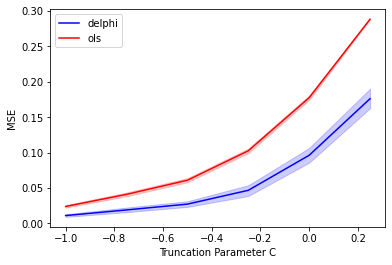

In [16]:
# plot results for regression parameter MSE
sns.lineplot(data=results, x='c', y='pred_param_mse', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='c', y='emp_param_mse', label='ols', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
plt.show()

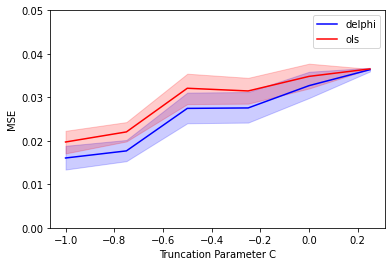

In [17]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='pred_var_mse', label='delphi', color="blue")
ax = sns.lineplot(data=results, x='c', y='emp_var_mse', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
ax.set(ylim=(0, .05))
plt.show()